In [1]:
import os
import sys
import json
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loguru import logger as log
from dtaidistance import dtw_visualisation as dtwvis

In [2]:
# Custom packages
from sediment_dtw import *
from utils import convert_warp_path_to_timeseries
from plotting import create_graph

In [3]:
log.remove()
log.add(sys.stderr, level="DEBUG");

In [4]:
%load_ext autoreload
%autoreload 2

#### Define initial parameters

For example, if biostratigraphic data indicates that the age of oldest sediments in the core cannot exceed 245,000 years, set the `max_age` variable to 245. Similarly, set the `min_age` variable to the minimum age you expect the core top to be. For piston core from the ocean bottom, it is a good idea to set this to 0, but if data is available, such as for example the topmost 10k years are missing, this variable can be set to start at something else than 0. 

In [29]:
min_age = 75  # in kiloyears (kyrs) before present
max_age = 600 # in kiloyears (kyrs) before present
time_step = 5  # in kiloyears

### Find optimal distance between two time-series

#### Run parameters

Define the name, location and variable (column) names of the target/reference curve here.

In [27]:
# ref = "LR04stack"
ref = "core_1100_conventional_agemodel"
# ref = "core_1100_dtw_agemodel"
ref_path = f'../data/{ref}.csv'
ref_cols = ['time', 'd18O']

#### Load target (reference) data and limit by `min_age` and `max_age`

Load target data, and filter by expected minimum and maximum age (`min_age`, `max_age`) 

In [30]:
target = pd.read_csv(ref_path, usecols=ref_cols) 
target = target[target['time'] <= max_age]
target = target[target['time'] >= min_age]

The next step is only executed if the dtw_age model for this specific core is to be used, in this case 1100. This age model was created in a previous iteration of this method.

In [30]:
if ref == "core_1100_dtw_agemodel":
    log.debug("Resampling reference time curve")
    target = pd.DataFrame(target.groupby('time', as_index=False)['d18O'].median())

In [31]:
target = target.reset_index(drop=True)

In [32]:
target.head(2)

,time,d18O
0,75.073792,-1.596
1,75.933031,-1.903


#### Load data curve (unknown time interval)

In [33]:
# Stable planktonic isotopes
# source = "../data/core_1100_d18O_pl.csv"
# source = "../data/core_1150_d18O_pl.csv"
source = "../data/tmp_1150_d18O_split_1.csv"

# Other data
# source = "../data/core_1100_d13C_pl.csv"
# source = "../data/core_1100_aragonite.csv"
# source = "../data/core_1150_aragonite.csv"
# source = "../data/core_1150_d18O_bulk.csv"
# source = "../data/core_1100_d13C_pl.csv"
# source = "../data/core_1100_d13C_bulk.csv"

In [34]:
source_name = source.split("/")
source_name = source_name[-1].split("_")[:2]
source_name = "_".join(source_name)

data = pd.read_csv(source, skip_blank_lines=True)
data.head(2)

,depth_m,d18O_pl,age_model_conv
0,2.06,-1.080,NaN
1,2.11,-1.324,NaN


In [35]:
source_name

'tmp_1150'

In [36]:
data_col = data.columns[1]
data_col

'd18O_pl'

#### Define DTW object

In [37]:
dtw = SedimentDTW(target=target, 
                  data=data, 
                  normalize=True, 
                  smooth=True, 
                  window_size=11, 
                  polynomial=3)

2023-04-29 21:16:37.332 | DEBUG    | sediment_dtw:__init__:91 - Time-warp object created successfully!


##### Find simple distance

In [38]:
simple_distance = dtw.simple_distance()
print(round(simple_distance, 2))

10.65


##### Find minimum distance iteratively

In [39]:
distance, time, min_distances = dtw.find_min_distance(min_age, max_age, time_step, warp_path=True)
print(f'Found minimum distance: {round(distance, 2)} at target time {time} kyrs')

2023-04-29 21:23:14.652 | DEBUG    | sediment_dtw:find_min_distance:194 - 5.230299126597494, 5.230299126597494


Found minimum distance: 5.23 at target time 110 kyrs


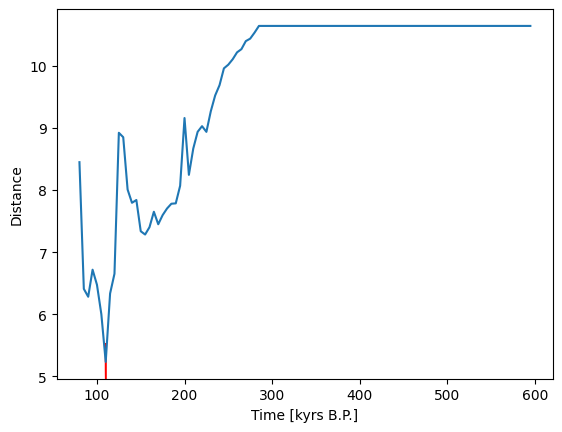

In [40]:
ax = sns.lineplot(x=min_distances.keys(), y=min_distances.values(), data=min_distances)
plt.xlabel("Time [kyrs B.P.]")
plt.ylabel("Distance")
ax.add_patch(plt.Circle((time, distance), 0.3, color="red"))

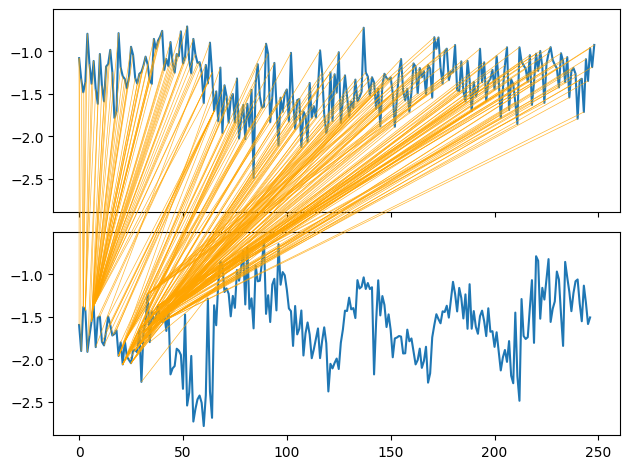

In [41]:
plot, ax = dtwvis.plot_warping(data.iloc[:,1], target.iloc[:,1], dtw.best_path)

In [42]:
dtw.best_path[:5]

[(0, 0), (0, 1), (1, 2), (2, 2), (3, 2)]

In [43]:
def select_all_pairs(warp_path, index):
    pairs = list()
    for pair in warp_path:
        if pair[0] == index:
            pairs.append(pair)
    return pairs

In [44]:
def select_max_from_pairs(pairs):
    values = list()
    for pair in pairs:
        values.append(pair[1])
    return max(values)

In [45]:
def convert_warp_path_to_timeseries(target: Union[list, np.array, pd.Series], 
                                    data: Union[list, np.array, pd.Series],
                                    warp_path: list[tuple]):
    
    dtw_time_axis = list()
    for index, _ in enumerate(data):
        pairs = select_all_pairs(warp_path, index)
        maximum = select_max_from_pairs(pairs)
        dtw_time_axis.append(target[maximum])

    assert len(dtw_time_axis) == len(data)
    return dtw_time_axis

In [46]:
dtw_time_axis = convert_warp_path_to_timeseries(target['time'], data['depth_m'], dtw.best_path)

In [47]:
data['time_dtw'] = dtw_time_axis

In [48]:
# Tmp changes to make visualisation & comparison easier
target['d18O_adjusted'] = target['d18O'] - 3
tmp_target = target[target['time'] <= 275]

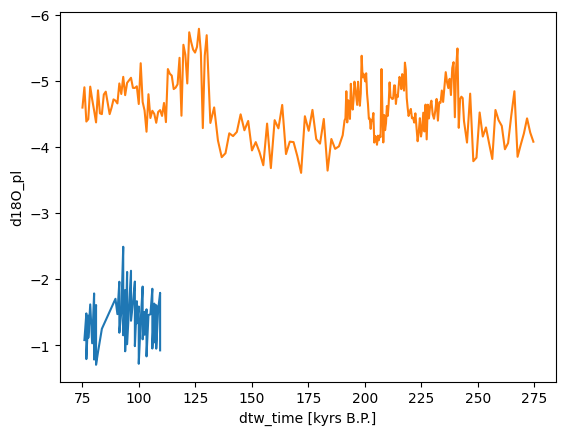

In [49]:
ax = sns.lineplot(x=data['time_dtw'], y=data[data_col], data=data, estimator=None)
sns.lineplot(x=tmp_target['time'], y=tmp_target['d18O_adjusted'], data=target, estimator=None)
ax.invert_yaxis()

In [50]:
fig = ax.get_figure()
fig.savefig(f"../out/{data_col}_{ref}_{source_name}_out.eps")

In [51]:
data.to_csv(f"../out/{data_col}_{ref}_{source_name}_out.csv", index=False)

In [52]:
data.columns

Index(['depth_m', 'd18O_pl', 'age_model_conv', 'dtw_time [kyrs B.P.]'], dtype='object')

In [75]:
tmp = pd.read_csv("../data/tmp_1150_d18O_split_0.csv")

In [76]:
tmp = tmp.append(data, ignore_index=True)

/tmp/ipykernel_1270/2748876192.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(data, ignore_index=True)


In [77]:
tmp

,depth_m,d18O_pl,age_model_conv,dtw_time [kyrs B.P.]
0,0.01,-1.891,0.00,NaN
1,0.06,-1.525,0.64,NaN
2,0.11,-2.421,1.28,NaN
3,0.16,-2.422,1.92,NaN
4,0.21,-1.562,2.56,NaN
...,...,...,...,...
285,14.26,-1.092,NaN,109.44333
286,14.31,-1.349,NaN,109.44333
287,14.36,-0.961,NaN,109.44333
288,14.41,-1.186,NaN,109.44333


In [53]:
time_depth_model = data[['depth_m','time_dtw']]

In [54]:
time_depth_model.to_csv(f"../out/tdm_{ref}_{source_name}.csv", index=False)